In [19]:
import os
import json 
import argparse
import numpy as np
import math
import pickle
import datetime
import time
import logging
import itertools
import sys

bgraphs_dir = '/home/althausc/master_thesis_impl/scripts'
sys.path.insert(0,bgraphs_dir) 

%load_ext autoreload
%autoreload 2


SyntaxError: invalid syntax (<ipython-input-19-2c081d90d1e9>, line 19)

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

You can specify an URL to an image

In [8]:
url = 'https://cdn.topofart.com/images/artists/John_Singer_Sargent/paintings/sargent029.jpg'
import urllib.request
urllib.request.urlretrieve(url, "input_img.jpg")
imgpath = os.path.abspath("input_img.jpg")

Or specify an image from the styletransfer art dataset:

In [ ]:
imgpath = '/home/althausc/nfs/data/coco_17_medium/val2017_styletransfer/000000000785_050351.jpg'

Show the loaded image:

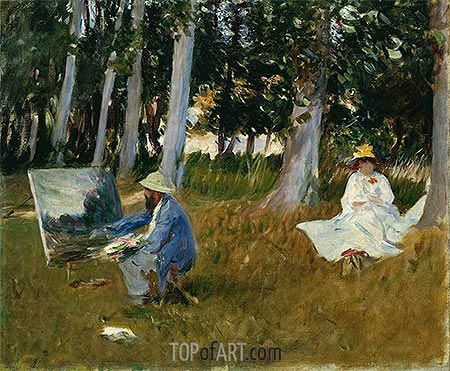

In [9]:
from IPython.display import Image, display
display(Image(filename=imgpath))

Run keypoint & scene graph inference:

/home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/out/visualize/10-02_15-33-36/1input_img_scenegraph.jpg
SCENE GRAPH PREDICTION ...
SCENE GRAPH PREDICTION DONE.

VISUALIZE SCENEGRAPH ...
VISUALIZE SCENEGRAPH DONE.


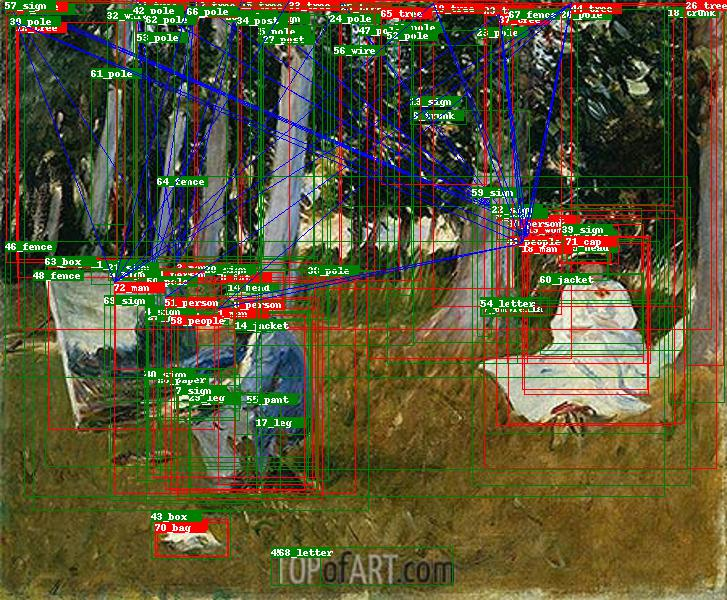

Box labels: 
0_woman; 0.5668892860412598
1_man; 0.4014948904514313
2_hat; 0.3000815212726593
8_person; 0.15720409154891968
10_person; 0.13828866183757782
12_tree; 0.1279689371585846
18_man; 0.07386387139558792
19_tree; 0.06265890598297119
29_tree; 0.03477263078093529
33_tree; 0.03078075498342514
37_tree; 0.026843801140785217
41_people; 0.024860307574272156
44_tree; 0.022800743579864502
49_tree; 0.0183127298951149
51_person; 0.017674827948212624
58_people; 0.01160398405045271
65_tree; 0.008833179250359535
70_bag; 0.005833479110151529
71_cap; 0.005793743766844273
72_man; 0.005721922032535076
Rel labels: 
37_tree => behind => 18_man; 0.8524168133735657	0
44_tree => behind => 72_man; 0.8459457755088806	1
37_tree => behind => 0_woman; 0.8368092775344849	2
12_tree => behind => 72_man; 0.8342700004577637	3
44_tree => behind => 18_man; 0.8291122913360596	4
19_tree => behind => 18_man; 0.828144907951355	5
44_tree => behind => 0_woman; 0.8093091249465942	8
8_person => watching => 18_man; 0.80830

In [21]:
import branchkpts.predict_search_modules as kptm
import branchgraphs.predict_search_modules as graphm

#Keypoint inference
#kpt_annpath = kptm.predict(imgpath)
#display(Image(filename="../branchkpts/input_img_overlay.jpg"))

#Graph inference
g_annpath = graphm.predict_scenegraph(imgpath)

filterlabels = True #False
imgpath, anns = graphm.visualize_scenegraph(g_annpath, filterlabels)
display(Image(filename=imgpath))

with open(anns, 'r') as f:
    print(f.read())

---
Transforms the keypoint predictions to a geometric feature descriptor. <br>
Please specify following parameters:

    Method for constructing the feature vector
    PCA params, if necessary because of too many feature entries [Model only used when pca enabled]

Transforms the scene graph predictions into necessary Graph2Vec format. 
Furthermore only the best k predictions will be considered. <br>
Please specify following parameters:
    
    Relasnodes for transforming the predicates to nodes.
    

In [25]:
#Transform poses to GPD descriptor
methodgpd = 'JcJLdLLa_reduced' #['JcJLdLLa_reduced', 'JLd_all']
pca_on = False #True
pca_model = '/home/althausc/master_thesis_impl/posedescriptors/out/08/27_13-49-24/modelpca64.pkl' 

gpdfile = kptm.transform_to_gpd(kpt_annpath, methodgpd, pca_on, pca_model)

#Transform graph predictions to G2V Format
relsasnodes = True
graphfile = graphm.transform_into_g2vformat(g_annpath,relsasnodes)

CALCULATE GPD DESCRIPTORS ...
CALCULATE GPD DESCRIPTORS DONE.
TRANSFORM PREDICTIONS INTO GRAPH2VEC FORMAT ...
TRANSFORM PREDICTIONS INTO GRAPH2VEC FORMAT DONE.


Search for images in the database with similar arrangements of persons. <br>
A database (Elastic Search) is queried with the given keypoint feature vector. <br>
Please specify following parameters: <br>
    1. tresh Threshold for minimum cos similarity scores (range=[0,1], only used by method 'COSSIM')
    2. method_search 
        - COSSIM uses cosinus similarity between query and each db image (cluster retrieval supported)
        - DISTSUM accumulates all L2-Distances from query to all db images


Search best matching image in reference to the computed scene graph. <br>
A pretrained model is used in query mode to infer best matching results.<br>
Please specify following parameters:<br>
    
    1. k Only obtain best k images according to pretrained G2V model(uses cosinus similarity)
    2. rw Reweight mode enabled, then retrieved images get reordered by similarities 
          in box & relationship label distribution
    3. rm Similarity metric between label distributions


In [29]:
#Search with pose descriptors
method_search = 'COSSIM' #['COSSIM', 'DISTSUM']
tresh = 0.95
topkkpt_file = kptm.search(gpdfile, method_search, methodgpd, tresh)

#Search with graph embeddings
k = 10
rw = False #True
rm = 'jaccard' #'euclid' 
topngraph_file = graphm.search_topk(graphfile, k, reweight=rw, r_mode=rm)


SEARCH FOR GPD IN DATABASE:
GPD file:  /home/althausc/master_thesis_impl/posedescriptors/out/09/04_18-37-54/geometric_pose_descriptor_c_2_m0_t0.50_f1.1_mkpt10.json
python3.6 /home/althausc/master_thesis_impl/retrieval/elastic_search_init.py -file /home/althausc/master_thesis_impl/posedescriptors/out/09/04_18-37-54/geometric_pose_descriptor_c_2_m0_t0.50_f1.1_mkpt10.json -search -method_search COSSIM                                                                                                 -gpd_type JcJLdLLa_reduced -tresh 0.95 &> /home/althausc/master_thesis_impl/results/logs/jupyter-notebook/kptbranch/4-search.txt



/home/althausc/master_thesis_impl/retrieval/out/humanposes/12-23-4-3
GRAPH2VEC PREDICTION & RETRIEVAL ...


RuntimeError: Scene graph search failed.

Merge resultlists & Show images in ranking.

In [ ]:
import ipyplot
import branchtogether as bb
#results = '/home/althausc/master_thesis_impl/retrieval/out/09/03_16-45-46/result-ranking.json'

topk = 20
w_branches = 0.5 #0-> kpts only, 1-> graphs only
im_dir, mergedres = bb.merge_retrievalresults(topkkpt_file, topngraph_file, topk=topk, weight_branches = w_branches)

imgs, scores = bb.getImgs(im_dir, mergedres)


queryim = bb.drawborder(imgpath)
imgs.insert(0,queryim)


ipyplot.plot_images(imgs, labels=None, scores=scores, max_images=30, img_width=250)